# Finding similar documents with Word2Vec and Soft Cosine Similarity 

Soft Cosine Similarity (SCS) is a promising new tool in machine learning that allows us to submit a query and return the most relevant documents. In **part 1**, we will show how you can compute SCS between two documents using `softcossim`. In **part 2**, we will use `SoftCosineSimilarity` to retrieve documents most similar to a query. Part 1 is optional if you only want use `SoftCosineSimilarity`, but is also useful in it's own merit.

First, however, we go through the basics of what soft cosine similarity is.

## Soft Cosine Similarity basics

Soft Cosine Similarity (SCS) is a method that allows us to assess the similarity between two documents in a meaningful way, even when they have no words in common. It uses a measure of similarity between words, which can be derived [2] using [word2vec](http://rare-technologies.com/word2vec-tutorial/) [3] vector embeddings of words. It has been shown to outperform many of the state-of-the-art methods in the semantic text similarity task in the context of community question answering [2].

SCS is illustrated below for two very similar sentences. The sentences have no words in common, but by matching the relevant words, SCS is able to accurately measure the similarity between the two sentences. The method also uses the bag-of-words vector representation of the documents (simply put, the word's frequencies in the documents). The intution behind the method is that we compute standard cosine similarity assuming that the document vectors are expressed in a non-orthogonal basis, where the angle between two basis vectors is derived from the angle between the word2vec embeddings of the corresponding words.

![Soft Cosine Similarity](soft_cosine_tutorial.png)


This method was introduced in the article "Soft Similarity and Soft Cosine Measure: Similarity of Features in Vector Space Model" by Grigori Sidorov, Alexander Gelbukh, Helena Gomez-Adorno, and David Pinto ([link to PDF](http://www.scielo.org.mx/pdf/cys/v18n3/v18n3a7.pdf)).

In this tutorial, we will learn how to use Gensim's SCS functionality, which consists of the `softcossim` method for distance computation, and the `SoftCosineSimilarity` class for corpus based similarity queries.

> **Note**:
>
> If you use this software, please consider citing [1] and [2].
>

## Running this notebook
You can download this [iPython Notebook](http://ipython.org/notebook.html), and run it on your own computer, provided you have installed Gensim, PyEMD, NLTK, Matplotlib, and downloaded the necessary data.

The notebook was run on an Ubuntu machine with an Intel core i7-6700HQ CPU 3.10GHz (4 cores) and 16 GB memory. Running the entire notebook on this machine takes about 6 minutes.

In [1]:
from time import time
start_nb = time()

# Initialize logging.
import logging
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s')

## Part 1: Computing the Soft Cosine Similarity

To use SCS, we need some word embeddings first of all. You could train a word2vec (see tutorial [here](http://rare-technologies.com/word2vec-tutorial/)) model on some corpus, but we will start by downloading some pre-trained word2vec embeddings. Download the GoogleNews-vectors-negative300.bin.gz embeddings [here](https://code.google.com/archive/p/word2vec/) (warning: 1.5 GB, file is not needed for part 2). Training your own embeddings can be beneficial, but to simplify this tutorial, we will be using pre-trained embeddings at first.

Let's take some sentences to compute the similarity between.

In [2]:
sentence_obama = 'Obama speaks to the media in Illinois'
sentence_president = 'The president greets the press in Chicago'
sentence_orange = 'Oranges are my favorite fruit'
sentence_obama = sentence_obama.lower().split()
sentence_president = sentence_president.lower().split()
sentence_orange = sentence_orange.lower().split()

The first two sentences have very similar content, and as such the SCS should be large. Before we compute the SCS, we want to remove stopwords ("the", "to", etc.), as these do not contribute a lot to the information in the sentences.

In [3]:
# Import and download stopwords from NLTK.
from nltk.corpus import stopwords
from nltk import download
download('stopwords')  # Download stopwords list.

# Remove stopwords.
stop_words = stopwords.words('english')
sentence_obama = [w for w in sentence_obama if w not in stop_words]
sentence_president = [w for w in sentence_president if w not in stop_words]
sentence_orange = [w for w in sentence_orange if w not in stop_words]

# Prepare a dictionary and a corpus.
from gensim import corpora
documents = [sentence_obama, sentence_president, sentence_orange]
dictionary = corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(document) for document in documents]

# Convert the sentences into bag-of-words vectors.
sentence_obama = dictionary.doc2bow(sentence_obama)
sentence_president = dictionary.doc2bow(sentence_president)
sentence_orange = dictionary.doc2bow(sentence_orange)

[nltk_data] Downloading package stopwords to /home/witiko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now, as mentioned earlier, we will be using some downloaded pre-trained embeddings. We load these into a Gensim Word2Vec model class. Note that the embeddings we have chosen here require a lot of memory. We will use the embeddings to construct a term similarity matrix that will be used by the `softcossim` method.

In [4]:
start = time()
import os

from gensim.models import KeyedVectors
if not os.path.exists('/data/GoogleNews-vectors-negative300.bin.gz'):
    raise ValueError("SKIP: You need to download the google news model")
    
model = KeyedVectors.load_word2vec_format('/data/GoogleNews-vectors-negative300.bin.gz', binary=True)
similarity_matrix = model.similarity_matrix(corpus, dictionary)
del model

print('Cell took %.2f seconds to run.' % (time() - start))

Cell took 107.69 seconds to run.


So let's compute SCS using the `softcossim` method.

In [6]:
from gensim.matutils import softcossim
similarity = softcossim(sentence_obama, sentence_president, similarity_matrix)
print('similarity = %.4f' % similarity)

similarity = 0.3361


Let's try the same thing with two completely unrelated sentences. Notice that the similarity is smaller.

In [7]:
similarity = softcossim(sentence_obama, sentence_orange, similarity_matrix)
print('similarity = %.4f' % similarity)

similarity = 0.0085


## Part 2: Similarity queries using `SoftCosineSimilarity`

You can use SCS to get the most similar documents to a query, using the `SoftCosineSimilarity` class. Its interface is similar to what is described in the [Similarity Queries](https://radimrehurek.com/gensim/tut3.html) Gensim tutorial.

### Yelp data

Let's try similarity queries using some real world data. For that we'll be using Yelp reviews, available at http://www.yelp.com/dataset_challenge. Specifically, we will be using reviews of a single restaurant, namely the [Mon Ami Gabi](http://en.yelp.be/biz/mon-ami-gabi-las-vegas-2).

To get the Yelp data, you need to register by name and email address. The data is 3.6 GB.

This time around, we are going to train the Word2Vec embeddings on the data ourselves. One restaurant is not enough to train Word2Vec properly, so we use 6 restaurants for that, but only run queries against one of them. In addition to the Mon Ami Gabi, mentioned above, we will be using:

* [Earl of Sandwich](http://en.yelp.be/biz/earl-of-sandwich-las-vegas).
* [Wicked Spoon](http://en.yelp.be/biz/wicked-spoon-las-vegas).
* [Serendipity 3](http://en.yelp.be/biz/serendipity-3-las-vegas).
* [Bacchanal Buffet](http://en.yelp.be/biz/bacchanal-buffet-las-vegas-7).
* [The Buffet](http://en.yelp.be/biz/the-buffet-las-vegas-6).

The restaurants we chose were those with the highest number of reviews in the Yelp dataset. Incidentally, they all are on the Las Vegas Boulevard. The corpus we trained Word2Vec on has 27028 documents (reviews), and the corpus we used for `SoftCosineSimilarity` has 6978 documents.

Below a JSON file with Yelp reviews is read line by line, the text is extracted, tokenized, and stopwords and punctuation are removed.


In [8]:
# Pre-processing a document.
from nltk.corpus import stopwords
from nltk import download, word_tokenize
download('punkt')  # Download data for tokenizer.
download('stopwords')  # Download stopwords list.
stop_words = stopwords.words('english')

def preprocess(doc):
    doc = doc.lower()  # Lower the text.
    doc = word_tokenize(doc)  # Split into words.
    doc = [w for w in doc if not w in stop_words]  # Remove stopwords.
    doc = [w for w in doc if w.isalpha()]  # Remove numbers and punctuation.
    return doc

[nltk_data] Downloading package punkt to /home/witiko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/witiko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
start = time()

import json

# Business IDs of the restaurants.
ids = ['4JNXUYY8wbaaDmk3BPzlWw', # Mon Ami Gabi
       'Ffhe2cmRyloz3CCdRGvHtA', # Earl of Sandwich
       'K7lWdNUhCbcnEvI0NhGewg', # Wicked Spoon
       'eoHdUeQDNgQ6WYEnP2aiRw', # Serendipity 3
       'RESDUcs7fIiihp38-d6_6g', # Bacchanal Buffet
       '2weQS-RnoOBhb1KsHKyoSQ'] # The Buffet

w2v_corpus = []  # Documents to train word2vec on (all 6 restaurants).
scs_corpus = []  # Documents to run queries against (only one restaurant).
documents = []  # scs_corpus, with no pre-processing (so we can see the original documents).
with open('/data/review.json') as data_file:
    for line in data_file:
        json_line = json.loads(line)
        
        if json_line['business_id'] not in ids:
            # Not one of the 6 restaurants.
            continue
        
        # Pre-process document.
        text = json_line['text']  # Extract text from JSON object.
        text = preprocess(text)
        
        # Add to corpus for training Word2Vec.
        w2v_corpus.append(text)
        
        if json_line['business_id'] == ids[0]:
            # Add to corpus for similarity queries.
            scs_corpus.append(text)
            documents.append(json_line['text'])

print('Cell took %.2f seconds to run.' %(time() - start))

Cell took 103.94 seconds to run.


Below is a plot with a histogram of document lengths and includes the average document length as well. Note that these are the pre-processed documents, meaning stopwords are removed, punctuation is removed, etc. Document lengths have a high impact on the running time of SCS, so when comparing running times with this experiment, the number of documents in query corpus (about 7000) and the length of the documents (about 59 words on average) should be taken into account.

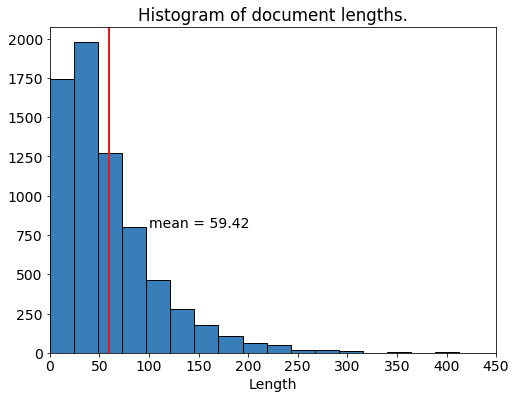

In [10]:
from matplotlib import cycler, pyplot as plt
%matplotlib inline

# Document lengths.
lens = [len(doc) for doc in scs_corpus]

# Plot.
plt.rc('figure', figsize=(8,6))
plt.rc('font', size=14)
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cycler('color', ('#377eb8','#e41a1c','#4daf4a',
                                           '#984ea3','#ff7f00','#ffff33')))
# Histogram.
plt.hist(lens, bins=20, edgecolor="k")
# Average length.
avg_len = sum(lens) / float(len(lens))
plt.axvline(avg_len, color='#e41a1c')
plt.title('Histogram of document lengths.')
plt.xlabel('Length')
plt.xlim((0, 450))
plt.text(100, 800, 'mean = %.2f' % avg_len)
plt.show()

Now we want to initialize the similarity class with a corpus and a word2vec model (which provides the embeddings and the `softcossim` method itself).

In [11]:
start = time()

from gensim.models import Word2Vec

# Train Word2Vec on all the restaurants.
model = Word2Vec(w2v_corpus, workers=3, size=100)

# Initialize SoftCosineSimilarity.
from gensim import corpora
from gensim.similarities import SoftCosineSimilarity
num_best = 10
dictionary = corpora.Dictionary(scs_corpus)
scs_corpus = [dictionary.doc2bow(document) for document in scs_corpus]
similarity_matrix = model.wv.similarity_matrix(scs_corpus, dictionary)
instance = SoftCosineSimilarity(scs_corpus, similarity_matrix, num_best=num_best)

print('Cell took %.2f seconds to run.' %(time() - start))

Cell took 41.35 seconds to run.


The `num_best` parameter decides how many results the queries return. Now let's try making a query. The output is a list of indeces and similarities of documents in the corpus, sorted by similarity.

Note that the output format is slightly different when `num_best` is `None` (i.e. not assigned). In this case, you get an array of similarities, corresponding to each of the documents in the corpus.

The query below is taken directly from one of the reviews in the corpus. Let's see if there are other reviews that are similar to this one.

In [12]:
start = time()

sent = 'Yummy! Great view of the Bellagio Fountain show.'
query = dictionary.doc2bow(preprocess(sent))

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print('Cell took %.2f seconds to run.' %(time() - start))

Cell took 47.43 seconds to run.


The query and the most similar documents, together with the similarities, are printed below. We see that the retrieved documents are discussing the same thing as the query, although using different words. The query talks about the food being "yummy", while the second best result talk about it being "good".

In [13]:
# Print the query and the retrieved documents, together with their similarities.
print('Query:')
print(sent)
for i in range(num_best):
    print()
    print('sim = %.4f' % sims[i][1])
    print(documents[sims[i][0]])

Query:
Yummy! Great view of the Bellagio Fountain show.

sim = 1.0000
Yummy!  Great view of the  Bellagio Fountain show.

sim = 0.8114
Food was good. Awesome service. Great view of the water show at the Bellagio

sim = 0.7813
This is a great place to eat after a show. Great atmosphere with the Bellagio Fountain across the street. The food is really good.

sim = 0.7719
Love this place!  It has a great atmosphere, the food is consistently good, if you sit on the patio you can watch the Fountain show of the Bellagio.

sim = 0.7680
Solid food; great service. Beautiful view of the Bellagio fountains across the street.

sim = 0.7627
Nice French food with a great view if the Bellagio fountains

sim = 0.7597
Great environment, great service and great food with relatively affordable price! What can be better than enjoying a glass of sweet Frangria under the sun while watching the fountain show at the Bellagio right across the street during your vacay?

sim = 0.7585
Amazing food, amazing service

Let us now remove the word "yummy" from the query. We can see that

> Food was good. Awesome service. Great view of the water show at the Bellagio

drops from the second to the seventh place even though it does not actually contain the word "yummy".

In [14]:
start = time()

sent = 'Great view of the Bellagio Fountain show.'
query = dictionary.doc2bow(preprocess(sent))

sims = instance[query]  # A query is simply a "look-up" in the similarity class.

print('Query:')
print(sent)
for i in range(num_best):
    print()
    print('sim = %.4f' % sims[i][1])
    print(documents[sims[i][0]])

print('Cell took %.2f seconds to run.' %(time() - start))

Query:
Great view of the Bellagio Fountain show.

sim = 0.9591
Yummy!  Great view of the  Bellagio Fountain show.

sim = 0.8020
Solid food; great service. Beautiful view of the Bellagio fountains across the street.

sim = 0.7899
Nice French food with a great view if the Bellagio fountains

sim = 0.7820
Food was good. Awesome service. Great view of the water show at the Bellagio

sim = 0.7797
This is a great place to eat after a show. Great atmosphere with the Bellagio Fountain across the street. The food is really good.

sim = 0.7684
Love this place!  It has a great atmosphere, the food is consistently good, if you sit on the patio you can watch the Fountain show of the Bellagio.

sim = 0.7648
Consistently good food with a view of the fountains at bellagio.

sim = 0.7641
Great food with a great view! Time it right with the bellagio fountains!

sim = 0.7631
Great environment, great service and great food with relatively affordable price! What can be better than enjoying a glass of sweet

## References

1. Grigori Sidorov et al. *Soft Similarity and Soft Cosine Measure: Similarity of Features in Vector Space Model*, 2014.
* Delphine Charlet and Geraldine Damnati, *SimBow at SemEval-2017 Task 3: Soft-Cosine Semantic Similarity between Questions for Community Question Answering*, 2017.
* Thomas Mikolov et al. *Efficient Estimation of Word Representations in Vector Space*, 2013.